# **Import Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

2025-07-01 15:15:16.334480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751382916.582054      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751382916.646564      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = '/kaggle/input/eurosat-dataset/EuroSAT'

# **Load CSVs**

In [3]:
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
val_df   = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df  = pd.read_csv(os.path.join(base_path, 'test.csv'))

train_df['Filename'] = train_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))
val_df['Filename']   = val_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))
test_df['Filename']  = test_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))

# **Exploratory Data Analysis**

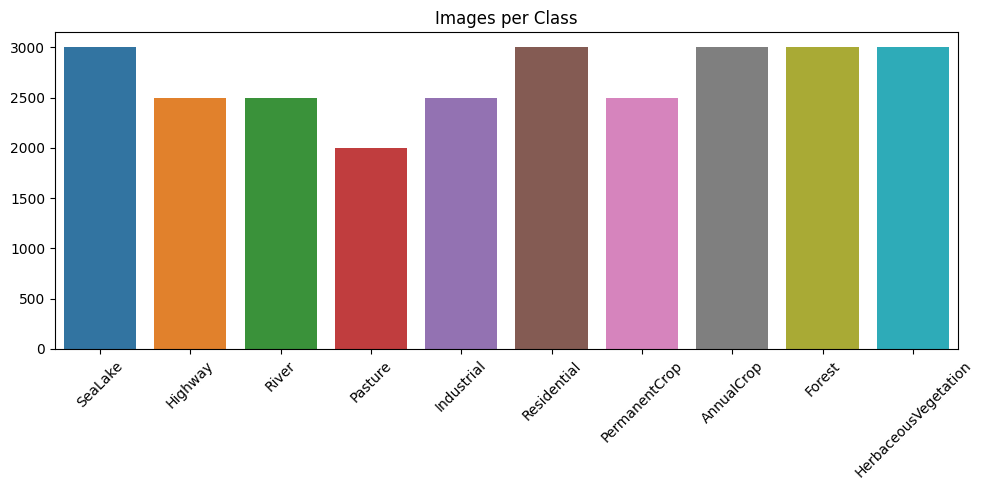

In [4]:
# Count images per class
class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))] 
class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in class_dirs}

plt.figure(figsize=(10, 5))

# Convert x to pd.Series; Removes warning of seaborn (Array)
sns.barplot(
    x=pd.Series(list(class_counts.keys())),
    y=list(class_counts.values())
)

plt.xticks(rotation=45)
plt.title("Images per Class")
plt.tight_layout()
plt.show()

# **Image Generators**

In [5]:
img_height, img_width = 64, 64
batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


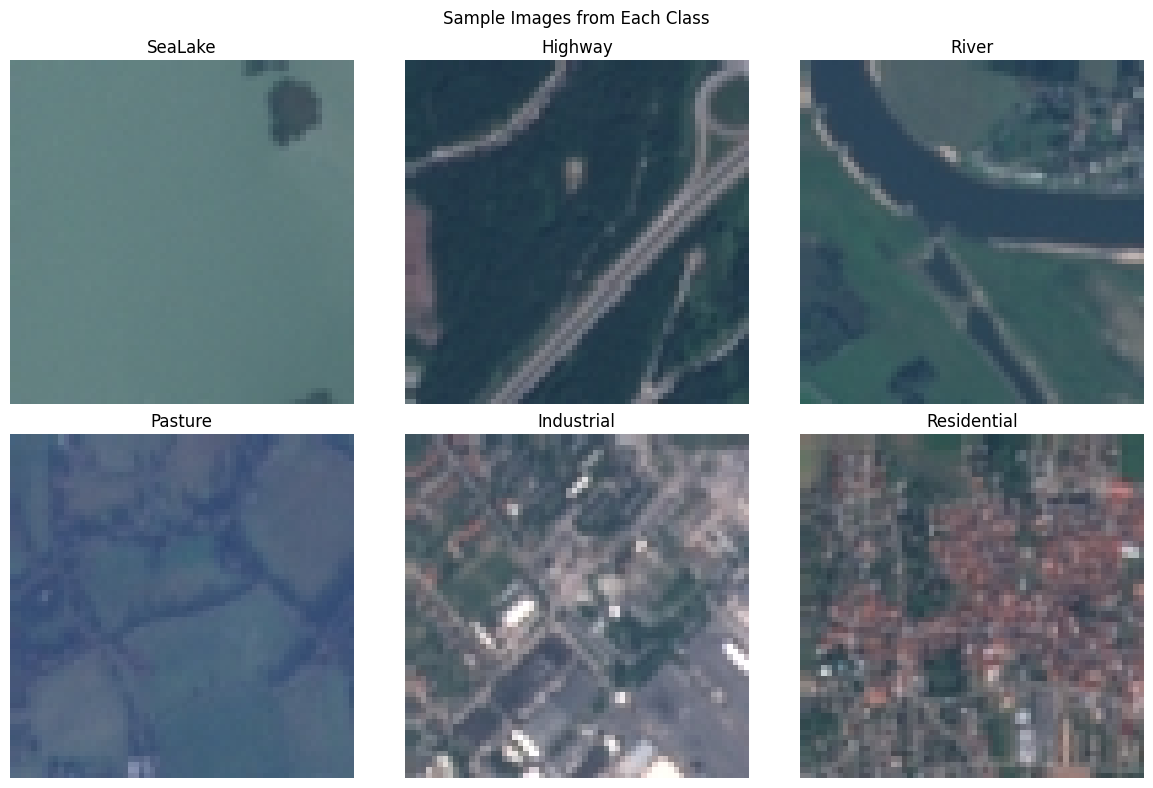

In [6]:
# Show one sample image per class (first 6)
plt.figure(figsize=(12, 8))
for i, cls in enumerate(class_dirs[:6]):
    class_path = os.path.join(base_path, cls)
    image_file = random.choice(os.listdir(class_path))
    img = load_img(os.path.join(class_path, image_file), target_size=(img_height, img_width))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()

# **CNN Model**

In [7]:
num_classes = len(train_generator.class_indices)

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model before training
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1751383033.528130      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751383033.528814      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # increase to 20 or more if needed
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751383038.861662      98 service.cc:148] XLA service 0x79c19c0052c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751383038.862745      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751383038.862777      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751383039.210417      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/296 ━━━━━━━━━━━━━━━━━━━━ 31:55 6s/step - accuracy: 0.1406 - loss: 2.3060

I0000 00:00:1751383042.375823      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


296/296 ━━━━━━━━━━━━━━━━━━━━ 180s 588ms/step - accuracy: 0.3022 - loss: 1.7860 - val_accuracy: 0.6144 - val_loss: 0.9996
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.6383 - loss: 1.0143 - val_accuracy: 0.7428 - val_loss: 0.7180
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.7121 - loss: 0.8159 - val_accuracy: 0.7270 - val_loss: 0.7565
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.7247 - loss: 0.7626 - val_accuracy: 0.7526 - val_loss: 0.6689
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.7414 - loss: 0.7121 - val_accuracy: 0.8017 - val_loss: 0.5730
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.7729 - loss: 0.6288 - val_accuracy: 0.7443 - val_loss: 0.6977
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.7826 - loss: 0.6070 - val_accuracy: 0.8300 - val_loss: 0.4897
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.8012 - loss: 0.5582 - val_accur

### *Accuracy on Test*

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2%}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - accuracy: 0.8506 - loss: 0.4277
Test Accuracy: 84.93%


### *Classification report*

In [10]:
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.77      0.84       600
              Forest       0.91      0.98      0.94       600
HerbaceousVegetation       0.71      0.80      0.75       600
             Highway       0.70      0.77      0.73       500
          Industrial       0.94      0.93      0.93       500
             Pasture       0.74      0.84      0.79       400
       PermanentCrop       0.80      0.61      0.69       500
         Residential       0.93      0.98      0.96       600
               River       0.80      0.75      0.77       500
             SeaLake       0.96      0.96      0.96       600

            accuracy                           0.84      5400
           macro avg       0.84      0.84      0.84      5400
        weighted avg       0.85      0.84      0.84      5400



### *Performance Analysis*

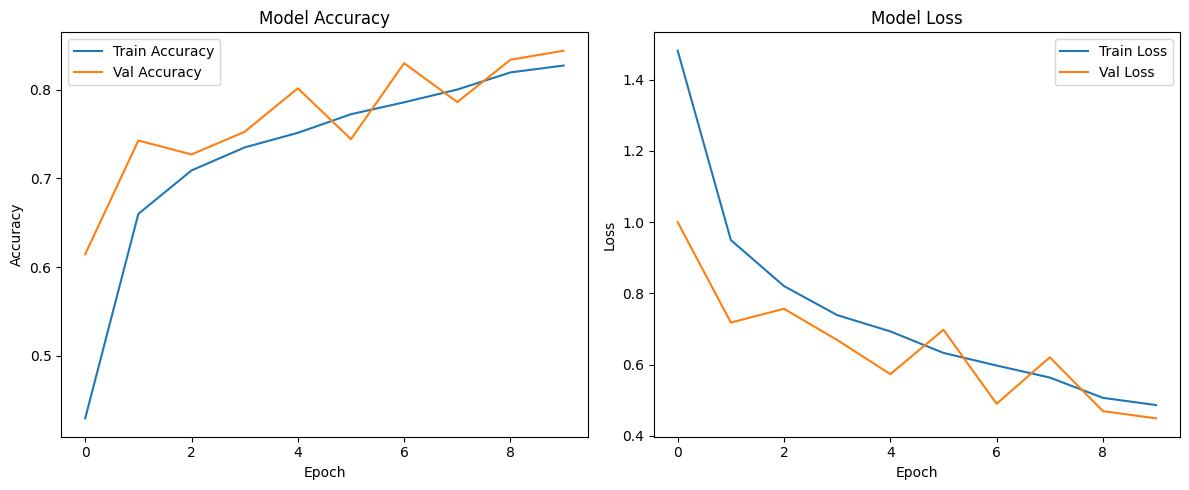

In [11]:
# Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# *Confusion matrix*

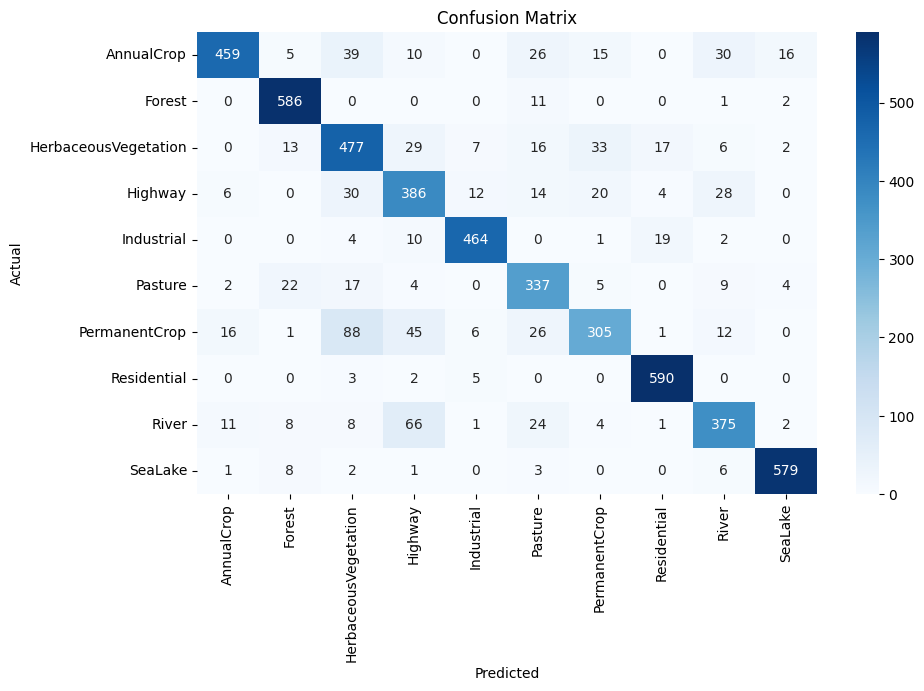

In [12]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **ANN Model**

In [13]:
# Convert 3D image input to 1D for ANN
input_shape_flat = img_height * img_width * 3
# Define ANN model architecture
ann_model = models.Sequential([
    layers.Input(shape=(input_shape_flat,)),   # Input layer (1D)
    layers.Dense(512, activation='relu'),      # First hidden layer
    layers.Dropout(0.3),                        # Dropout for regularization
    layers.Dense(256, activation='relu'),      # Second hidden layer
    layers.Dropout(0.3),                        # Dropout again
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

In [14]:
# Compile ANN model
ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Convert generator output to flat input for ANN
def flatten_generator(generator):
    X, y = [], []
    for batch_x, batch_y in generator:
        batch_flat = batch_x.reshape(batch_x.shape[0], -1)
        X.extend(batch_flat)
        y.extend(batch_y)
        if len(X) >= generator.samples:
            break
    return np.array(X), np.array(y)

# Apply to train and validation sets
X_train_ann, y_train_ann = flatten_generator(train_generator)
X_val_ann, y_val_ann = flatten_generator(val_generator)

In [16]:
# Train the ANN model
ann_history = ann_model.fit(
    X_train_ann, y_train_ann,
    validation_data=(X_val_ann, y_val_ann),
    epochs=10
)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2023 - loss: 2.5660 - val_accuracy: 0.2674 - val_loss: 1.8453
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2361 - loss: 1.9306 - val_accuracy: 0.3452 - val_loss: 1.8448
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2375 - loss: 1.9589 - val_accuracy: 0.3187 - val_loss: 1.7896
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2708 - loss: 1.8725 - val_accuracy: 0.3313 - val_loss: 1.7223
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2648 - loss: 1.8641 - val_accuracy: 0.3046 - val_loss: 1.7374
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2849 - loss: 1.8528 - val_accuracy: 0.3372 - val_loss: 1.7107
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2750 - loss: 1.8528 - val_accuracy: 0.3430 - val_loss: 1.7243
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2783 - loss: 1.8439 - val_accuracy: 0.

# **Performance Comparison: CNN vs ANN**

CNN Validation Accuracy: 0.8441
ANN Validation Accuracy: 0.3369


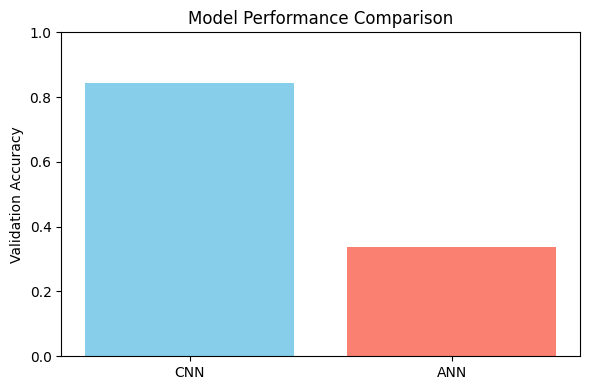

In [17]:
cnn_val_acc = history.history['val_accuracy'][-1]
ann_val_acc = ann_history.history['val_accuracy'][-1]

print(f"CNN Validation Accuracy: {cnn_val_acc:.4f}")
print(f"ANN Validation Accuracy: {ann_val_acc:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['CNN', 'ANN'], [cnn_val_acc, ann_val_acc], color=['skyblue', 'salmon'])
plt.ylabel('Validation Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()